# Word Vectors and Language Models

## Word Definitions
- *Named Entity Recognition* is a technique in extrinsic word vector evaluation that involves identifying named entities such as a person, organization, or location—for example, in the sentence "Chris Manning lives in Palo Alto", "Chris Manning" is a person and "Palo Alto" is a location.
- *Sparse coding* is a method of representing data using a large number of potential features, but where only a few are active (non-zero) at a time.
- *Word senses* refer to the different meanings a single word can have depending on context, such as "bank" meaning a financial institution or the side of a river
- In *Supervised Learning* we have a training dataset consisting of samples $(x_i, x_i)^{N}_{i=1}$ where $x_i$ are the inputs i.e. words (vectors), sentences, documents etc., and $y_i$ are the classes of the labels we are trying to predict i.e., location, person.
- A *Linear Classifier* is a model that makes predictions by drawing a straight (linear) decision boundary to separate different classes based on input features.
- *Antonym* is a word that has the opposite meaning of another word. *Hot* is an antonym of *cold.*
- *Synonym* is a word that has the same or nearly the same meaning as another word. *Happy* is a synonym of *joyful*

---


# Optimisation Basics

At the end of the previous Module (Module_001 - Word Vectors) we looked at calculating the dervivatives of word2vec. This was simply saying that we had this loss function and our job was to work out its derivatives which would tell us which direction to walk downhill to get some minimum

The cost function, $J(\theta)$, we want to minimise can be done so using *gradient descent*. The general idea is for the current value of $\theta$, calculate the gradient of $J(\theta)$ and then take a small step in the direction of negative gradient. 

## Gradient Descent

- The update rule is

$$
\theta^{\text{new}} = \theta^{\text{old}} - \alpha 	\nabla_{\theta}J(\theta)
$$

where:
- $\alpha$ is the learning rate
- $\theta$ corresponds to the $\text{old}$ and $\text{new}$ parameters
- $\bigtriangledown_{\theta}$ is the gradient
- $J(\theta)$ is the loss function


The algorithm is
```python
while: True
    theta_grad = evaluate_gradient(J, corpus, theta)
    theta = theta - alpha * theta_grad
```

However, we do not use this as it is too computationally expensive. Instead we use Stochastic Gradient Descent

## Stochastic Gradient Descent

Instead of computing the gradient using the entire dataset, SGD uses just one example (or small window) at a time. This makes updates faster and more scalable. This is also often known as *mini batch gradient descent* 

This process:
- Reduces computation time
- Adds noise to updates (which can help escape local minima)
- Is ideal for large-scale learning like Word2Vec

The algorithm is
```python
while: True
    window = sample_window(corpus)
    theta_grad = evaluate_gradient(J, window, theta)
    theta = theta - alpha * theta_grad
```

## How to Learn the Word Vector:

The basic training loop:
```
1. start with random numbers for each word vector.

2. Feed a pair like ("cat", "sat") into the model.

3. The model tries to predict "sat" from "cat":

4. If it's wrong → calculate how far off it was (loss).

5. Use gradient descent to adjust the numbers in the vectors to reduce that error.

6. Repeat for millions of word pairs in the corpus.
```

Over time, the model learns:

- "Cat" is often near "sat", "meows", "pet"
- So "cat" and those words should have similar vector values
- While "cat" and "spaceship" shouldn't — so their vectors diverge


## Main idea of word2vec

1. Randomly initialise word vectors
2. Iterate through each word position in the whole corpus
3. Predict the surrounding words using vectors: $$P(o \mid c) = \frac{\exp(u_o^\top v_c)}{\sum_{w \in V} \exp(u_w^\top v_c)}$$
4. Update the vectors, using the gradients, so they can predict surrounding words better

The only parameters of the word2vec model are the word vectors (outside, and center)

Word2Vec has two main architecture variants for learning word embeddings: **Skip-Gram (SG)** and **Continuous Bag of Words (CBOW)**. Both aim to capture the semantics of words based on their surrounding context, but they do so in opposite directions.

---

### Skip-Gram (SG)

- **Goal**: Predict **context (outside)** words given a **center** word.
- For a given word in the corpus, the model learns to predict the words that appear nearby within a fixed window size.
- Each training pair is of the form:  
  `(center word → context word)`
- **Position-independent**: It doesn't try to predict the position of the context word, just that it occurred within the window.

**Example**  
In the sentence:  
> "The quick brown fox jumps"

If **"brown"** is the center word and the window size is 2, the training examples would be:  
- (brown → quick)  
- (brown → the)  
- (brown → fox)  
- (brown → jumps)

**Advantages**:
- Works well with **small datasets**
- Can represent rare words better, since each word contributes multiple context predictions

### Negative Sampling (Used in Skip-Gram)

In the **standard skip-gram model**, we compute this probability:

$$
P(o \mid c) = \frac{\exp(u_o^\top v_c)}{\sum_{w \in V} \exp(u_w^\top v_c)}
$$

This is a **softmax function** over the entire vocabulary `V`, which can be **very large** (millions of words).  
As a result, computing this for every training step becomes **very slow**.

#### Negative Sampling to the Rescue

Instead of predicting the exact probability using softmax, we simplify the problem.

The idea is:
- Train the model to **distinguish between "real" word pairs and "fake" ones**
- A "real" pair: a center word and one of its actual context words (e.g. `("cat", "meows")`)
- A "fake" pair: a center word and a **random word** not from the context (e.g. `("cat", "laptop")`)

#### How It Works

1. For each training pair (center word `c`, context word `o`), treat it as a **positive example** (`label = 1`)
2. Sample a few **random noise words** (`w_1, w_2, ..., w_k`) from the vocabulary to create **negative examples** (`label = 0`)
3. Train a small logistic regression classifier to predict whether each pair is a **real pair or a fake**.

#### Instead of Softmax, We Do This:

For a real pair (`c`, `o`):

$$
\text{maximize: } \log \sigma(u_o^\top v_c)
$$

For each fake pair (`c`, `w_i`), sampled from a noise distribution:

$$
\text{maximize: } \log \sigma(-u_{w_i}^\top v_c)
$$

Where:
- `σ(x)` is the **sigmoid function** (used in logistic regression)
- `u` = context vector, `v` = center vector

#### Why It's Efficient

- Only computes a few dot products per update (not one for every word in the vocabulary)
- Much faster for large vocabularies
- Works very well in practice — widely used in Word2Vec

---

### Continuous Bag of Words (CBOW)

- **Goal**: Predict the **center word** given its **surrounding context** words.
- Takes the average (or sum) of the context word vectors and tries to guess the missing center word.
- Each training pair is of the form:  
  `(context words → center word)`
- Treats context as a **bag of words**: word order is ignored.

**Example**  
In the sentence:  
> "The quick brown fox jumps"

If the context window is 2 and the center word is **"brown"**, the context words would be:  
- ["The", "quick", "fox", "jumps"]

So the training pair would be:  
- (["The", "quick", "fox", "jumps"] → brown)

**Advantages**:
- Faster to train
- Generally performs well on **frequent words**

### Summary of Differences

| Feature            | Skip-Gram                | CBOW                        |
|--------------------|--------------------------|-----------------------------|
| Task               | Predict context words     | Predict center word         |
| Input              | Center word              | Context words (bag)         |
| Output             | Context words            | Center word                 |
| Focus              | Better for rare words    | Better for frequent words   |
| Computational cost | Slower                   | Faster                      |





## How to Evaluate Word Vectors

In NLP, evaluating word vectors can be done through two broad approaches: **intrinsic** and **extrinsic** evaluation.

Both evaluation types are useful:  
- Intrinsic for diagnosing and understanding embeddings  
- Extrinsic for validating their real-world impact

### Intrinsic Evaluation

- Evaluation on a **specific subtask** that tests semantic properties of word embeddings.
- Examples include:
  - **Word similarity**: Do vector distances match human judgments?  
    (e.g., cosine similarity between "cat" and "dog" should be high)
  - **Word analogy tasks**:  
    (e.g., "man" is to "king" as "woman" is to "queen")
- **Advantages**:
  - Fast and easy to compute
  - Helps understand whether vectors capture basic word relationships
- **Disadvantages**:
  - May not correlate with performance on real-world NLP tasks
  - Can be too simplistic to reflect real language use

###  Extrinsic Evaluation

- Evaluation by using the word vectors in a **downstream NLP task**, such as:
  - Sentiment analysis
  - Named entity recognition
  - Machine translation
  - Text classification
- **Advantages**:
  - Measures how useful embeddings are in real-world applications
- **Disadvantages**:
  - Slower and more computationally expensive
  - Hard to isolate whether poor performance is due to the embeddings or other parts of the system (e.g., model architecture, data preprocessing)




## Superposition in Word Vectors

*Superposition* is the idea that a single component (dimension) in a word vector does not represent just one specific feature, but instead participates in representing **many overlapping features** at once.

- Superposition means **one dimension contributes to multiple features**.
- It helps compress high-dimensional meaning into low-dimensional vectors.
- It reflects the **distributed nature of meaning** in both AI and neuroscience.

### Why Superposition Happens

When we train word vectors (like in Word2Vec), we're using a **fixed-size vector** (e.g., 100 or 300 numbers) to represent **thousands of possible word properties**, such as:
- Gender (male/female)
- Tense (past/present)
- Category (animal, emotion, object)
- Frequency, common usage, and more

There are far more **features of meaning** than there are dimensions in the vector.

So the model learns to "compress" multiple features into the **same dimensions**. This means:
> Each number in a word vector contributes to **many different kinds of meaning**, depending on the context.

This overlapping encoding is called **superposition**.

### Example

Let's say one component in a vector contributes to:
- Masculine/feminine distinction in one context
- Singular/plural distinction in another
- Verb/noun in another

It's like the same light switch controlling several different lights — which ones it affects depends on what other switches (dimensions) are on.

### Analogy: Superposition in the Brain

This is similar to how the brain works:
- A single neuron may respond to **multiple concepts**, not just one.
- Patterns of activation (not individual units) encode meaning.

### Why It Matters

- Superposition makes word vectors **very efficient**: we can represent a lot of information in a small space.
- But it also makes them **hard to interpret** — there's no simple mapping like "dimension 4 = emotion".
- This also explains why **small changes** to a word vector can shift its meaning subtly.


## Deep Learning Classification: Named Entity Recognition (NER)

The task in *Named Entity Recognition (NER)* is to **find** and **classify** names in text by labelling word tokens with categories such as **Location**, **Person**, **Date**, etc.

###  Why NER Is Useful

NER has many practical applications, including:
- **Tracking mentions** of specific people, places, or organizations across documents
- **Question answering**, where answers are often named entities
- **Sentiment analysis**, where it's useful to link opinions to the entity being discussed

### A Simple NER Model (Typical ML Approach)

One way to perform NER is with a simple, traditional classifier:
- Classify **each word** based on its **context window** (e.g., surrounding 2–3 words)
- Use a **logistic regression classifier** trained on hand-labelled data
- The input to the classifier is the **concatenation of word vectors** from the window

**Example Workflow**:
1. Input: `"Chris Manning lives in Palo Alto"`
2. Center word: `"Manning"`
3. Context: `"Chris"` (before), `"lives"` (after)
4. Input to model: `[vec(Chris) || vec(Manning) || vec(lives)]`
5. Output: `"Manning"` → *Person*

### A More Complex Model: Neural Network Classifier

Deep learning-based NER systems learn **richer representations** and offer more power and flexibility.

#### **Typical ML / Softmax Classifier**:

- Learns only the **weight matrix** $W$.
- Input $x$ is usually a **sparse vector** (e.g., one-hot encoding).
- Uses a **linear decision boundary**, which may be too limited for complex patterns.
- No internal understanding of relationships between words — relies entirely on surface features.

#### **Neural Network Classifier**:

- Learns **both**:
  - The classifier weights ($W$)
  - The **input representations** (dense word vectors)

- Input words are first passed through an **embedding layer**:
  $$
  x = L e
  $$
  Where:
  - `L` is the embedding matrix
  - `e` is the one-hot vector for a word
  - `x` is the resulting **dense word embedding**

- Word embeddings are **distributed representations**:
  - Each vector encodes many semantic features (via *superposition*)
  - Words with similar meanings get similar vectors

- The final layer is still a **softmax classifier**, but:
  - It's applied to transformed inputs from one or more **hidden layers**
  - This makes the model **non-linear with respect to the original input**
  - Enables learning more abstract, useful patterns in language

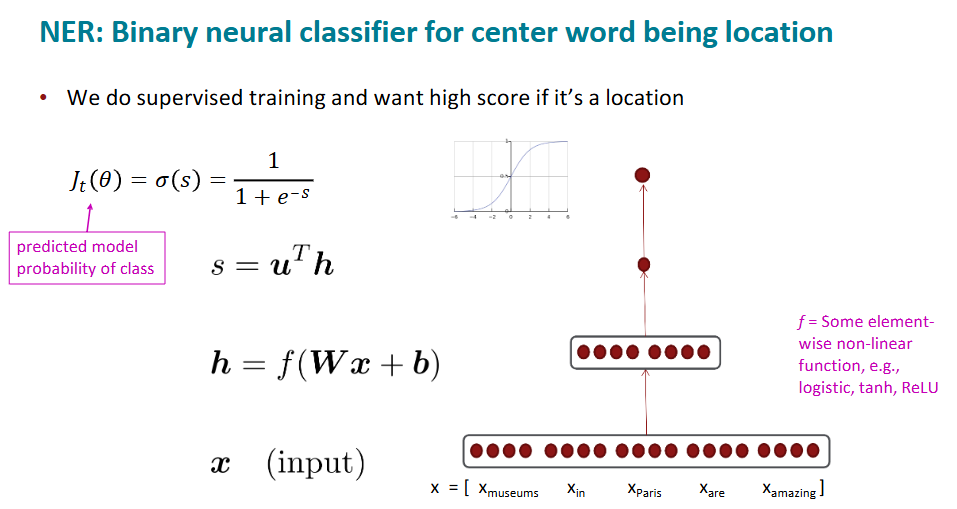

## Training with Cross-Entropy Loss

Previously, we described our objective as **maximizing the probability of the correct class** $y_i$, or equivalently, **minimizing the negative log-probability** of that class on the training data:

$$
\text{Loss} = -\log p(y_i \mid x_i)
$$

Now we introduce a more general way to express this idea using a concept from information theory: **cross-entropy**.

### What Is Cross-Entropy?

Cross-entropy measures the difference between two probability distributions:
- Let **p** be the true (target) distribution
- Let **q** be the model's predicted probability distribution

The cross-entropy between them is:

$$
H(p, q) = - \sum_{i} p(i) \log q(i)
$$

### In Classification

In classification tasks, we usually assume the **true distribution** $p$ is a **one-hot vector**:
- The correct class has probability 1
- All other classes have probability 0

So $p = [0, ..., 0, 1, 0, ..., 0]$

In this case, the cross-entropy simplifies to:

$$
\text{Loss} = -\log q(y_i)
$$

That is: we only care about the predicted probability of the **true class**, and we want it to be as high as possible.

### Why Use Cross-Entropy?

- It directly **penalizes wrong predictions** more heavily the more confident they are.
- It is mathematically well-aligned with **maximum likelihood training**.
- It works well with **softmax output layers**, where outputs are normalized probabilities over classes.

### Using Cross-Entropy in PyTorch

In PyTorch, use the built-in loss function:

```python
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

